In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import multivariate_normal, wishart
from bambi import Model, Prior
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
root = "../data/"
survNA = pd.read_csv(root+"survCleanWithSomeNA.csv", index_col=0).sort_values(["year", "sitecode"])
survNA.head()

,age,bmi,grade,q13,q18,q25,q26,q47,q57,qnobese,...,q32,q69,q46,q19,q12,q8,q9,q41,q40,q27
122831,6.0,NaN,3.0,1.0,1.0,2.0,2.0,1.0,2.0,NaN,...,1.0,1.0,1.0,NaN,1.0,3.0,1.0,1.0,1.0,2.0
122832,NaN,18.048443,1.0,1.0,1.0,2.0,2.0,6.0,2.0,NaN,...,3.0,1.0,4.0,2.0,5.0,4.0,4.0,2.0,5.0,2.0
122833,1.0,22.401235,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,...,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0
122834,3.0,29.518950,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,7.0,1.0,2.0,3.0,5.0,1.0,1.0,4.0,1.0
122835,3.0,21.520933,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,1.0,2.0


In [32]:
cols = ["age", "bmi", "q13", "q18", "q27", "q32", "q19"]
X = survNA.sample(100)[cols]
#X = X[~X.isna().all(axis=1)]
X_imputed = bayesian_impute(X, samples=10)
X_imputed.head()

Number of missing values:
age     0
bmi    11
q13     7
q18    31
q27    37
q32     6
q19    23
dtype: int64


,age,bmi,q13,q18,q27,q32,q19
330402,3.0,21.700617,1.0,2.358583,1.923393,1.000000,2.086422
364863,4.0,23.923891,1.0,1.674327,2.333322,1.000000,2.585963
323876,5.0,22.733803,1.0,0.888216,1.628545,0.846168,1.814359
192709,3.0,20.404844,1.0,1.000000,2.000000,1.000000,2.000000
154806,4.0,24.657484,1.0,1.000000,2.000000,1.000000,2.000000


In [6]:
def update_missing_data(row, Sigma, theta, p):
    """ imputes missing data for a dataframe row. Generates random value from
    multivariate normal based on adjusted mean/variance

    Args:
        row (pd.Series): row of dataframe. includes all covariates and columns
            indicating if corresponding variable observed or missing
        Sigma (np.array): covariance matrix
        theta (np.array): mean vector
        p (int): number of covrariates

    Returns:
        pd.Series: row with imputed data. obesrved values remain the same
    """
    # create indices for observed/missing data
    missing = (row[p:] == 0).to_numpy()
    obs = (row[p:] == 1).to_numpy()
    if missing.sum() == 0: #nothing to do if all data observed
        return row[:p]

    
    iS_a = np.linalg.inv(np.asarray(Sigma[obs][:,obs]))
    beta_j = Sigma[missing,][:,obs] @ iS_a
    Simga_j = (Sigma[missing][:,missing] - 
        Sigma[missing][:,obs] @ iS_a @ Sigma[obs][:,missing])
    theta_j = theta[missing] + beta_j @ (row[:p][obs] - theta[obs])

    impute_vals = multivariate_normal.rvs(theta_j, Simga_j)
    row[:p][missing] = impute_vals

    return row[:p]


In [23]:
def bayesian_impute(X, samples=100):
    """imputes missing data for matrix of covariate data

    Args:
        X (pd.DataFrame): covariate data. should not include response
        samples (int, optional): number of iterations to run MCMC, default is low
            so should increase this to > 1000

    Raises:
        ValueError: data must not contain any rows that are missing all data

    Returns:
        pd.DataFrame: data with imputed values. existing observed data remains
            unchanged
    """
    if X.isna().all(axis=1).sum() > 0:
        raise ValueError("Some responses are missing data for all questions")

    X_updated = X.copy()

    print("Number of missing values:")
    print(X_updated.isna().sum())
    
    # setup initial values
    n = X_updated.shape[0]
    p = X_updated.shape[1]
    mu_o = X_updated.mean(axis=0)
    sd_o = mu_o / 2
    L_o = np.full((p, p), 0.1)
    np.fill_diagonal(L_o, 1)
    L_o = L_o * np.outer(sd_o, sd_o)
    nu_o = p + 2
    S_o = L_o
    Sigma = S_o

    # setup indicator matrix for observed/missing values
    O = 1 * (~X_updated.isna())
    O.columns = [x + "_obs" for x in O.columns]

    X_updated.fillna(mu_o, inplace=True)

    for s in range(samples):
        
        # update theta
        xbar = X_updated.mean()
        L_o_inv = np.linalg.inv(L_o)
        Sigma_inv = np.linalg.inv(Sigma)
        L_n = np.linalg.inv(L_o_inv  + (n * Sigma_inv))
        mu_n = L_n @ (L_o_inv @ mu_o + n * Sigma_inv @ xbar)
        theta = multivariate_normal.rvs(mean=mu_n, cov=L_n)

        # update sigma
        S_n = S_o + (X_updated - theta).T @ (X_updated - theta)
        Sigma = np.linalg.inv(wishart.rvs(nu_o + n, np.linalg.inv(S_n)))

        full = pd.concat([X_updated, O], axis=1)
        
        # update missing data
        X_updated.iloc[:,:p] = full.apply(
            update_missing_data,
            Sigma=Sigma,
            theta=theta,
            p=p,
            axis=1)

    return X_updated


In [33]:
X.mean()

age     4.750000
bmi    23.721447
q13     1.064516
q18     1.202899
q27     1.920635
q32     1.265957
q19     1.870130
dtype: float64

In [34]:
X_updated.mean()

age         4.837725
bmi        23.217705
q27         1.864581
q40         3.115642
qnobese     1.870401
q13         1.107101
dtype: float64

In [ ]:
#generate sample from data just for testing
#dat_2005 = dat_2005.sample(2000, random_state=551)
#dat_2005["car_risk_score"] = dat_2005["car_risk_score"] + 1

root = "../data/"
survNoNA = pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0).sort_values(["year", "sitecode"])
survNoNA = survNoNA.sample(2000, random_state=551)
survNoNA["carRiskScore"] = survNoNA["carRiskScore"] + 1
county_idxs, counties = pd.factorize(survNoNA["sitecode"]) # needed for hierarchical model
year_idxs, years = pd.factorize(survNoNA["year"])
coords = {
    "county": counties,
    "year": years,
    "obs_id": np.arange(len(county_idxs)),
}

In [ ]:
with pm.Model(coords=coords) as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    year_idx = pm.Data("year_idx", year_idxs, dims="obs_id")

    # Define priors
    #sigma = pm.Gamma("sigma", alpha=.01, beta=.01)
    intercept = pm.Normal("Intercept", 0, sigma=.001, dims="year")
    X = survNoNA[["age", "bmi"]]#survNoNA.drop(["carRiskScore", "sitecode"], axis=1)
    #beta = pm.Normal("beta", 1, sigma=10, shape=X.shape[1])
    question_betas = []
    for i, q in enumerate(X.columns):
        q_beta = pm.Normal("beta" + str(i), 1, sigma=10, dims="county")
        question_betas.append(q_beta)
    #mu_est = intercept[year_idx]
    mu_est = None
    for i, b in enumerate(question_betas):
        if mu_est is None:
            mu_est = b[county_idx] * X.iloc[:,i]
        else:
            mu_est += b[county_idx] * X.iloc[:,i]

    # Define likelihood
    likelihood = pm.Gamma(
        "y",
        #mu=intercept[county_idx] + pm.math.dot(X, beta),
        alpha=intercept[year_idx] + mu_est,
        beta=100,
        observed=dat_2005["car_risk_score"], dims="obs_id")
    #print(pm.distributions.shape_utils.to_tuple(likelihood.shape))
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #trace = pm.sample(3000, return_inferencedata=True)

    #pm.sample_posterior_predictive(trace, var_names=["x"])

In [ ]:
with model:
    trace = pm.sample(100, return_inferencedata=True, target_accept=0.9)
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"])

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, Intercept]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 90 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9737961692190497, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.999435382890744, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [ ]:
with model:
    approx = pm.fit()

Finished [100%]: Average Loss = 1.4949e+05


In [ ]:
approx.sample()[0]

{'Intercept': array([-0.13405697, -0.18237783, -0.14235681,  0.09245967,  0.14445425,
         0.19990115,  0.03192565, -0.0008244 , -0.15781145, -0.18578878,
         0.06339932, -0.02972709, -0.06359579, -0.06780464,  0.19846251,
         0.09505527]),
 'beta0': array([ 0.20024427,  1.20507486,  1.21321424, -0.06818118,  0.84404835,
        -0.06933231, -0.00689128,  0.48389195,  0.56684952,  1.10896461,
         0.61909059,  0.48430989, -0.1224021 , -0.0837237 ,  0.01228873,
         0.49009857]),
 'beta1': array([ 0.29002871,  0.14457296,  0.34643901,  0.8036162 ,  0.21543769,
        -0.2177284 ,  0.31566113,  0.50675479,  0.62560964,  0.68077638,
         0.62775988,  0.15136493,  0.16846578, -0.44586303, -0.64952099,
         0.52997242]),
 'beta2': array([ 0.11414546, -0.08135413,  0.03261023,  0.25478063,  0.60589281,
         0.17721207,  0.11852158,  0.52342399,  0.48514975,  0.13783932,
         0.38415431,  0.59320019, -0.03290921, -0.09275824,  0.10870191,
        -0.0822

Model Checking using extreme risk scores

In [ ]:
threshold = 500
y_pred = ppc["y"].ravel()
(y_pred > threshold).sum() / y_pred.shape[0] * 100

0.8106333333333333

In [ ]:
(d["car_risk_score"] > threshold).sum() / d.shape[0] * 100

5.35

Posteriors

In [ ]:
trace["posterior"]["Intercept"].mean(axis=1).mean(axis=0)

<xarray.DataArray 'Intercept' (year: 8)>
array([-1.12945307e-05,  2.72790831e-05,  3.09811743e-05, -9.51270966e-05,
        4.32835379e-05, -3.16090212e-05, -1.14654698e-06,  1.41344323e-05])
Coordinates:
  * year     (year) int64 2005 2007 2019 2009 2017 2015 2013 2011

In [ ]:
trace["posterior"]["beta"].mean(axis=1).mean(axis=0)

<xarray.DataArray 'beta' (beta_dim_0: 42)>
array([ 0.04193462,  2.21147322, -0.12590578, -4.44222118,  0.04580159,
        0.84422828, -2.17199115,  1.89782359,  1.87158427, -2.8352238 ,
       -1.51948074,  1.27821781,  4.06445621, -2.49474252,  2.86567833,
        3.96155926,  1.35426137, -0.15945564,  2.7444114 , -1.36986351,
        4.81179482, -5.60435428,  1.40885847, -6.64042714,  2.09663982,
        1.53048519,  0.78630122,  0.08926084, -0.60183046,  1.03730451,
       -4.63797695, -2.94037446, -3.09766493, -2.96920986,  8.95169639,
        5.88946865, -0.09959246,  1.6969421 , -0.82686616,  0.63526875,
        7.59657035, -0.2195706 ])
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41

In [ ]:
ppc

{'y': array([[6.15338258e+01, 2.65132678e-08, 4.58644277e-02, ...,
         2.57793881e+02, 8.86695514e-01, 3.68170897e+00],
        [1.95312259e+02, 2.56040777e+02, 7.79994016e-02, ...,
         1.46988487e+02, 2.34895084e+01, 4.16819282e-01],
        [3.06129017e+02, 1.99876836e+01, 1.58422021e-05, ...,
         7.59159444e+00, 2.02663529e+01, 5.44587289e+00],
        ...,
        [5.04086002e+02, 8.41621650e+01, 1.47229782e+01, ...,
         9.40602794e+01, 6.56257355e+01, 1.33946004e-35],
        [2.57183710e+01, 6.96138978e-12, 4.67791407e+02, ...,
         1.40305160e+02, 4.02212749e+01, 6.48357753e+01],
        [6.84474996e+01, 3.79664942e+01, 4.80828329e-05, ...,
         7.31520511e+01, 3.67922417e+00, 8.38387943e-06]])}

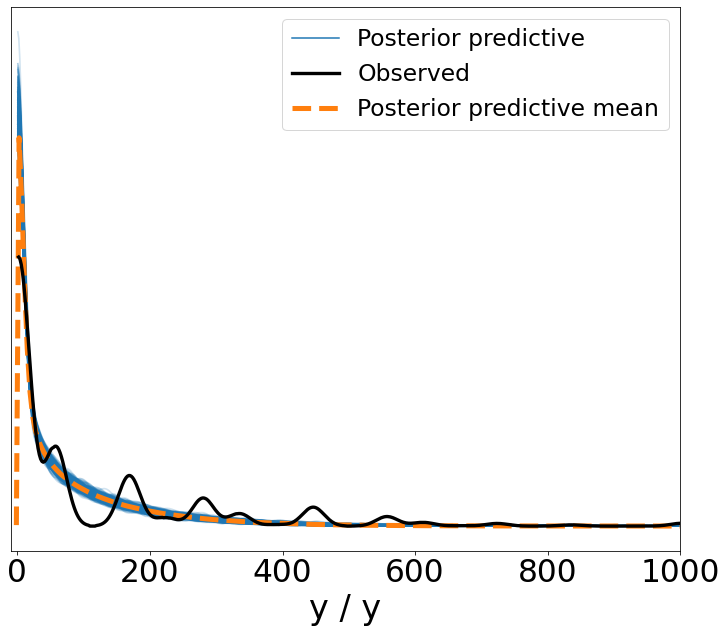

In [ ]:
ax = az.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(12, 10))
_ = ax.set_xlim((-10, 1000))

In [ ]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

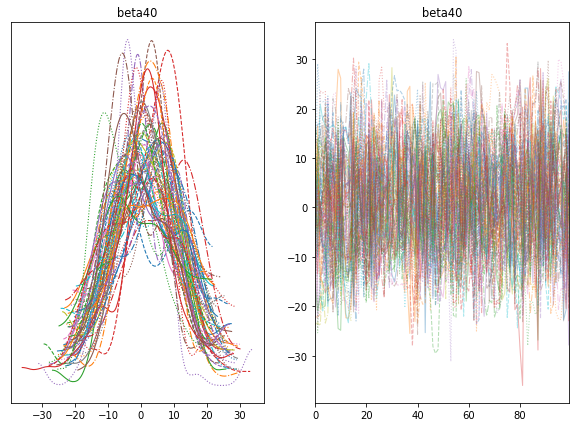

In [ ]:
_ = az.plot_trace(trace["posterior"]["beta40"][:,:,], figsize=(10, 7))